In [8]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm
keras = tf.keras

### Analytic Solution of Black-Scholes model

In [9]:
def BlackScholes(tau, S, K, sigma, alldata = None):
    d1=np.log(S/K)/sigma/np.sqrt(tau)+0.5*sigma*np.sqrt(tau)
    d2=d1-sigma*np.sqrt(tau)
    price=(S*norm.cdf(d1)-K*norm.cdf(d2))
    delta=norm.cdf(d1) 
    gamma=norm.pdf(d1)/(S*sigma*np.sqrt(tau))
    vega=S*norm.pdf(d1)*np.sqrt(tau)
    theta=-.5*S*norm.pdf(d1)*sigma/np.sqrt(tau)
    if alldata:
        data = {'npv':price,'delta':delta,'gamma':gamma,'vega':vega,'theta':theta}
        return data
    else:
        return price
    
    
N=100 # time disrectization    
S0=1 # initial value of the asset
T=1 # maturity
strike = 1.0
sigma=0.2 # volatility in Black Scholes    
BlackScholes(T, S0, strike, sigma)

0.07965567455405798

### Build neural networks at each trading time

In [10]:
def build_network(m, n , d, N, red):
# architecture is the same for all networks
    Networks = []
    trainable = True
    for j in range(N):
        if j > N/2 and red:
            trainable = False
        inputs = keras.Input(shape=(m,))
        x = inputs
        for i in range(d):
            if i < d-1:
                nodes = n
                layer = keras.layers.Dense(nodes, activation='tanh',trainable=trainable,
                          kernel_initializer=keras.initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(j) + 'step' + str(i) + 'layer')
                x = layer(x)
            else:
                nodes = m
                layer = keras.layers.Dense(nodes, activation='linear', trainable=trainable,
                              kernel_initializer=keras.initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                              bias_initializer='random_normal',
                              name=str(j) + 'step' + str(i) + 'layer')
                outputs = layer(x)
                network = keras.Model(inputs = inputs, outputs = outputs)
                Networks.append(network)
    return Networks

m = 1 # dimension of price
d = 3 # number of layers in strategy
n = 32  # nodes in the first but last layers
red = False
Networks = build_network(m, n , d, N, red)
Network0 = keras.layers.Dense(m, use_bias=False)
print('neural network at time 0.36 is: ')
Networks[36].summary()

neural network at time 0.36 is: 
Model: "model_137"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_138 (InputLayer)       [(None, 1)]               0         
_________________________________________________________________
36step0layer (Dense)         (None, 32)                64        
_________________________________________________________________
36step1layer (Dense)         (None, 32)                1056      
_________________________________________________________________
36step2layer (Dense)         (None, 1)                 33        
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


### Build the deep hedging dynamic 

In [11]:
price = keras.Input(shape=(N+1,m))   # S_{t}; t=0,..,N+1; (batch, N+1, m)
price_difference = price[:,1:,:] - price[:,:-1,:]  # dS_{t}; t=0,..,N; (batch, N, m)
hedge = tf.zeros_like(price[:,0,:])  # X_{0} = 0; (batch, m)
premium = Network0(tf.ones_like(price[:,0,:])) # premium; (batch, m)
for j in range(N):
    strategy = Networks[j](price[:,j,:])  # H_{t} = nn(S_{t}); (batch, m)
    hedge = hedge + strategy * price_difference[:,j,:]   # dX_{t} = H_{t}dS_{t}; (batch, m)
outputs = premium + hedge # premium + \int_{0}^{T}H_{t}dS_{t}; (batch, m)
model_hedge = keras.Model(inputs=price, outputs=outputs)

### Generate price paths of Black-Scholes model
$$
S_{t} = S_{0}e^{\sigma W_{t} - \frac{\sigma^{2}}{2}t}
$$

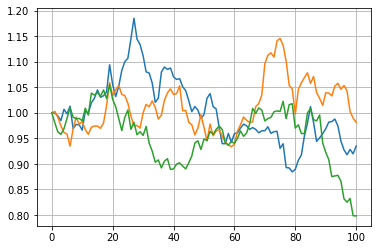

In [12]:
time_grid = np.linspace(0,T,N+1)
dt = T/N
Ktrain = 10**5

BM_path_helper = np.cumsum(np.random.normal(size = [Ktrain,N,m], loc=0, scale=np.sqrt(dt)),axis = 1)
BM_path = np.concatenate([np.zeros([Ktrain,1,m]),BM_path_helper],axis = 1)
price_path = S0 * np.exp(sigma * BM_path - 0.5 * sigma **2 * time_grid[None,:,None])

payoff_function = lambda x : 0.5*(np.abs(x-strike)+x-strike) 
payoff = payoff_function(price_path[:,-1,:])

plt.plot(price_path[:3,:,0].T)
plt.grid()
plt.show()

In [13]:
xtrain = price_path
ytrain = payoff
model_hedge.compile(optimizer='adam',loss='mse')
model_hedge.fit(x=xtrain,y=ytrain, epochs=300,verbose=True,batch_size=1000)

Epoch 1/300
10/10 [==============================] - 16s 234ms/step - loss: 1.9205
Epoch 2/300
10/10 [==============================] - 2s 236ms/step - loss: 1.8790
Epoch 3/300
10/10 [==============================] - 2s 237ms/step - loss: 1.8471
Epoch 4/300
10/10 [==============================] - 2s 246ms/step - loss: 1.8194
Epoch 5/300
10/10 [==============================] - 2s 241ms/step - loss: 1.7912
Epoch 6/300
10/10 [==============================] - 3s 254ms/step - loss: 1.7643
Epoch 7/300
10/10 [==============================] - 3s 289ms/step - loss: 1.7384
Epoch 8/300
10/10 [==============================] - 3s 283ms/step - loss: 1.7131
Epoch 9/300
10/10 [==============================] - 3s 286ms/step - loss: 1.6867
Epoch 10/300
10/10 [==============================] - 3s 275ms/step - loss: 1.6617
Epoch 11/300
10/10 [==============================] - 3s 279ms/step - loss: 1.6368
Epoch 12/300
10/10 [==============================] - 3s 275ms/step - loss: 1.6120
Epoch 13/300

10/10 [==============================] - 3s 287ms/step - loss: 0.3261
Epoch 100/300
10/10 [==============================] - 3s 288ms/step - loss: 0.3189
Epoch 101/300
10/10 [==============================] - 3s 289ms/step - loss: 0.3117
Epoch 102/300
10/10 [==============================] - 3s 289ms/step - loss: 0.3049
Epoch 103/300
10/10 [==============================] - 3s 289ms/step - loss: 0.2982
Epoch 104/300
10/10 [==============================] - 3s 291ms/step - loss: 0.2915
Epoch 105/300
10/10 [==============================] - 3s 294ms/step - loss: 0.2849
Epoch 106/300
10/10 [==============================] - 3s 291ms/step - loss: 0.2784
Epoch 107/300
10/10 [==============================] - 3s 290ms/step - loss: 0.2720
Epoch 108/300
10/10 [==============================] - 3s 289ms/step - loss: 0.2658
Epoch 109/300
10/10 [==============================] - 3s 289ms/step - loss: 0.2596
Epoch 110/300
10/10 [==============================] - 3s 290ms/step - loss: 0.2538
Epoch 

10/10 [==============================] - 3s 288ms/step - loss: 0.0201
Epoch 197/300
10/10 [==============================] - 3s 287ms/step - loss: 0.0194
Epoch 198/300
10/10 [==============================] - 3s 284ms/step - loss: 0.0187
Epoch 199/300
10/10 [==============================] - 3s 286ms/step - loss: 0.0180
Epoch 200/300
10/10 [==============================] - 3s 286ms/step - loss: 0.0173
Epoch 201/300
10/10 [==============================] - 3s 288ms/step - loss: 0.0167
Epoch 202/300
10/10 [==============================] - 3s 289ms/step - loss: 0.0161
Epoch 203/300
10/10 [==============================] - 3s 286ms/step - loss: 0.0155
Epoch 204/300
10/10 [==============================] - 3s 292ms/step - loss: 0.0149
Epoch 205/300
10/10 [==============================] - 3s 288ms/step - loss: 0.0143
Epoch 206/300
10/10 [==============================] - 3s 286ms/step - loss: 0.0138
Epoch 207/300
10/10 [==============================] - 3s 286ms/step - loss: 0.0133
Epoch 

10/10 [==============================] - 3s 286ms/step - loss: 4.1642e-04
Epoch 293/300
10/10 [==============================] - 3s 288ms/step - loss: 4.0371e-04
Epoch 294/300
10/10 [==============================] - 3s 290ms/step - loss: 3.9445e-04
Epoch 295/300
10/10 [==============================] - 3s 339ms/step - loss: 3.8142e-04
Epoch 296/300
10/10 [==============================] - 3s 332ms/step - loss: 3.7051e-04
Epoch 297/300
10/10 [==============================] - 3s 307ms/step - loss: 3.6228e-04
Epoch 298/300
10/10 [==============================] - 3s 297ms/step - loss: 3.5646e-04
Epoch 299/300
10/10 [==============================] - 3s 295ms/step - loss: 3.4423e-04
Epoch 300/300
10/10 [==============================] - 3s 293ms/step - loss: 3.3683e-04


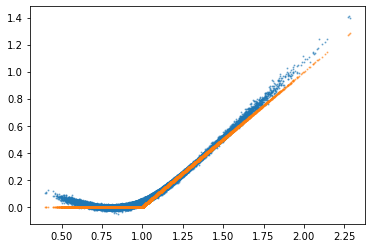

In [14]:
hedge_output = model_hedge.predict(xtrain)
plt.scatter(price_path[:,-1,0], hedge_output[:,0], s = 1, alpha = 0.5)
plt.scatter(price_path[:,-1,0], payoff[:,0], s = 1, alpha = 0.5)

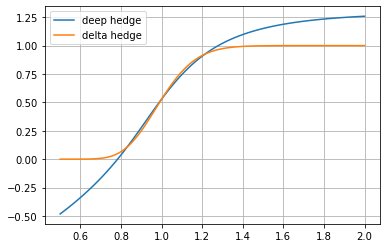

In [42]:
pr = tf.linspace(0.5,2,100)[:,None]
he = Networks[50](pr)
plt.plot(pr[:,0],he[:,0], label = 'deep hedge')

tau = 50/N
S = pr.numpy()[:,0]
K = strike
d1=np.log(S/K)/sigma/np.sqrt(tau)+0.5*sigma*np.sqrt(tau)
delta=norm.cdf(d1) 
plt.plot(S,delta, label = 'delta hedge')

plt.legend()
plt.grid()

In [44]:
Network0(tf.ones([1,1])).numpy()[0,0], BlackScholes(T, S0, strike, sigma)

(0.08982749, 0.07965567455405798)